# (Conserved) Phase Field Crystal (PFC) Model

FiPy implementation of of (Provatas & Elder, 2009): Figure 8.14

## Imports

**note:** The PETSc solvers are unable to solve matrix generated by this problem, as it's block structure is not block-diagonal (see [#840][#840]).

[#840]: https://github.com/usnistgov/fipy/issues/840

In [1]:
import os
os.environ['FIPY_SOLVERS'] = 'scipy'

In [1]:
import fipy as fp

In [18]:
from matplotlib import cm

## Parameters

The parameters are not given for Fig. 8.14, but they can be obtained from the conditions for Fig. 7 in (Elder & Grant, 2004)

> $(r, \bar{\psi}, \mathcal{D}, \Delta x, \Delta t) = (-1/4, 1/4, 0, \pi / 4, 0.0075)$

(**note:** $r = 1/4$ appears to be a typo, as that would place the system in the "Constant Phase").

The governing equation in Elder & Grant is

> $$\begin{align*}
\frac{\partial \psi}{\partial t}
&= \nabla^2\left(
    \omega\left(
        \nabla^2\right)\psi + \psi^3
\right) + \zeta
\tag{28}
\end{align*}$$
where $\langle\zeta(\vec{r}_1, \tau_1)\zeta(\vec{r}_2, \tau_2)\rangle = \mathcal{D}\delta(\vec{r}_1 - \vec{r}_2)\delta(\tau_1 - \tau_2)$
and $\mathcal{D} \equiv u k_B T q_0^{d-4}/\lambda^2$

and

> $$
\omega\left(\nabla^2\right)
= r + \left(1 + \nabla^2\right)^2
\tag{27}
$$

such that

$$\begin{align*}
\frac{\partial \psi}{\partial t}
&= \nabla^2\left(
    \left(r + (1 + \nabla^2)^2\right)\psi
     + \psi^3
\right) + \zeta
\tag{E&G}
\end{align*}$$

The governing equation in Provatas & Elder

> $$\begin{align*}
\frac{\partial n}{\partial t}
&= \Gamma\nabla^2\left[
    \left(B^\ell + B^x\nabla^2\left(2 + \nabla^2\right)\right)n
    - t n^2 + vn^3
\right] + \eta
\tag{8.84}
\end{align*}$$

> where $\langle\eta(\vec{r}_1, \tau_1)\eta(\vec{r}_2, \tau_2)\rangle = -2 k_B T \rho_l \delta(\vec{r}_1 - \vec{r}_2)\delta(\tau_1 - \tau_2)$

can be rearranged to 

$$\begin{align*}
\frac{\partial n}{\partial t}
&= \Gamma\nabla^2\left[
    \left(\Delta B + B^x\left(1 + \nabla^2\right)^2\right)n
    - t n^2 + vn^3
\right] + \eta
\tag{P&E}
\end{align*}$$

Comparing Eq. (E&G) with Eq. (P&E), we can relate the coefficients by

$$\begin{align*}
\Delta B &\equiv B^\ell - B^x = r & t &= 0
\\
B^x &= 1 & v &= 1
\\
\Gamma &= 1 & -2 k_B T \rho_l &= \mathcal{D}
\end{align*}$$

such that

$$(\Delta B, B^x, t, v, n_0, \Gamma, \mathcal{D}, \Delta x, \Delta t) = (-1/4, 1, 0, 1, 1/4, 1, 0, \pi / 4, 0.0075)$$

In [17]:
deltaB = -1/4
Bx = 1
Bl = Bx + deltaB
t = 0
v = 1
n0 = 1/4
Gamma = 1
D = fp.Variable(name=r"$\mathcal{D}$", value=0)
dx = fp.numerix.pi / 4
dt = 0.0075

We exploit FiPy's semi-implicit solvers to substantially increase the time step

In [3]:
timeStep = fp.Variable(name=r"$\Delta t$", value=dt*1000)

## Domain

In [4]:
nx = ny = 64
Lx = nx * dx
Ly = ny * dx
mesh = fp.PeriodicGrid2D(nx=nx, dx=dx, ny=ny, dy=dx)

## Equations

>$$
\frac{\partial n}{\partial t}
= \Gamma\nabla^2\left[
    \left(B^\ell + B^x\left(2\nabla^2 + \nabla^4\right)\right)n
    - t n^2 + vn^3
\right] + \eta
\tag{8.84}
$$

In [5]:
n = fp.CellVariable(mesh=mesh, name=r"$n$", value=n0, hasOld=True)

Arranging in a form more palatable for FiPy

$$\begin{align*}
\frac{\partial n}{\partial t}
&= \Gamma\nabla^2\left[
    \left(B^\ell + B^x\nabla^2\left(2 + \nabla^2\right)\right)n
    - t n^2 + vn^3
\right] + \eta
\\
&= \Gamma\nabla^2\left[
    \left(B^\ell n + B^x\nabla^2 \xi\right)
    - t n^2 + vn^3
\right] + \eta
\\
&= \Gamma\nabla^2\mu + \eta
\end{align*}
$$

In [6]:
mu = fp.CellVariable(mesh=mesh, name=r"$\mu$")

In [7]:
noise = fp.GaussianNoiseVariable(mesh=mesh, variance=D/(mesh.cellVolumes * timeStep))

In [8]:
n_eq = (fp.TransientTerm(coeff=1, var=n) == fp.DiffusionTerm(coeff=Gamma, var=mu) + noise.faceGrad.divergence)

where

$$\mu \equiv
\left(B^\ell n + B^x\nabla^2 \xi\right)
- t n^2 + vn^3
$$

In [9]:
xi = fp.CellVariable(mesh=mesh, name=r"$\xi$")

In [10]:
mu_eq = (fp.ImplicitSourceTerm(coeff=1, var=mu)
           == fp.ImplicitSourceTerm(coeff=Bl - t * n + v * n**2, var=n)
           + fp.DiffusionTerm(coeff=Bx, var=xi))

and

$$\xi \equiv \left(2 + \nabla^2\right)n$$

In [11]:
xi_eq = (fp.ImplicitSourceTerm(coeff=1, var=xi)
         == fp.ImplicitSourceTerm(coeff=2, var=n)
         + fp.DiffusionTerm(coeff=1, var=n))

We solve $n$, $\mu$, and $\xi$ together

In [12]:
eq = n_eq & mu_eq & xi_eq

## Initial Conditions

As a first step to the vacancy diffusion problem of Figure 8.14, we generate the equilibrium structure by initializing $n$ with Gaussian noise

In [13]:
n.setValue(fp.GaussianNoiseVariable(mesh=mesh, mean=n0, variance=.1))

## Visualize results

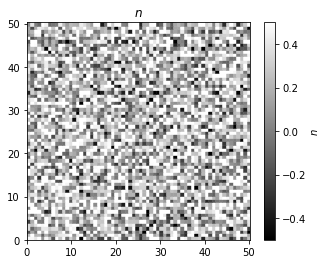

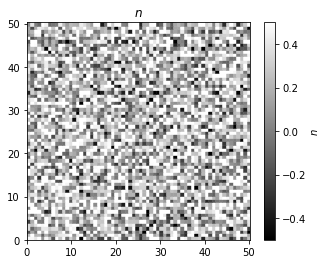

In [14]:
viewer = fp.Viewer(vars=n, cmap=cm.gray, datamin=-0.5, datamax=0.5)
viewer.plot()

## Solution

In [15]:
elapsed = 0

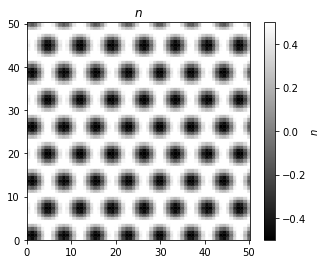

<Figure size 432x288 with 0 Axes>

In [16]:
for step in range(1000):
    noise.scramble()
    n.updateOld()
    eq.solve(dt=timeStep)
    elapsed += timeStep.value
    viewer.plot()

## References

K. R. Elder and M. Grant, 
"Modeling elastic and plastic deformations in nonequilibrium processing using phase field crystals", 
*Phys. Rev. E* **70** (2004) 051605

N. Provatas and K. Elder, 
*Phase-Field Methods in Materials Science and Engineering*, 
Wiley-VCH, 2009